cashflow volatility for energy producers due to weather
Future markets: history of application in agriculture to hedge against such uncertainties in revenue streams

Use of simple binary prediction market as a weather derivative to reduce the revenue uncertainty

Whether the wind speed for a particular time period at a nominated location is less than a certain threshold. In such market two shares (contracts) are offered, corresponding to possible answers to 
this question. Traders resemble role of speculators an WPP is a hedger who takes an offsetting position in the market. 

Which number of shares available at particular price level's should be purchased by the hedger to balance their expected revenue from the physical electricity and prediction markets

Two solutions:
- Indifference Pricing Strategy
- Utility Maximising Strategy

## Phase 1: Modeling the Probability Distribution of Wind Speed

Wind speed is a crucial factor in determining the electricity generation of a wind power producer (WPP). Since wind speeds are naturally variable and uncertain, we model them using a probability distribution. This allows us to understand the likelihood of different wind speeds occurring over a given period and assess how this uncertainty affects revenue.

1. Choosing a Probability Distribution for Wind Speed

Empirical studies show that wind speed at a given location often follows a Weibull distribution, which provides a good fit for the observed data. The Weibull distribution is defined by two parameters:
- Shape parameter (k): Determines the shape of the distribution and reflects the variability of wind speeds. Higher values of k indicate a more peaked distribution, while lower values indicate a flatter distribution.
- Scale parameter (c): Represents the scale of wind speeds and influences the location of the distribution along the wind speed axis.

For this example, we assume a Weibull distribution with a shape parameter of 10 and a scale parameter of 8 (as specified in the paper). Using these parameters, we can generate synthetic wind speed data.

2. Generating Wind Speed Data

We generate one million wind speed samples to simulate the variability of wind conditions. This large dataset allows us to approximate the real-world distribution of wind speeds. By sampling from the Weibull distribution, we obtain a set of wind speed values that represent different scenarios.

3. Computing the Probability Density Function (PDF) and Cumulative Distribution Function (CDF)

To visualize the distribution of wind speeds:
- The PDF shows the relative likelihood of different wind speeds occuring
- The CDF indicates the probability that wind speeds will be below a certain threshold

The median wind speed, denoted as $v_e$, is used as the threshold in our predictive market. The CDF at $v_e$ gives us the probability $p$ that wind speed will be below this threshold, which is an essential input for pricing the predictive market contract.

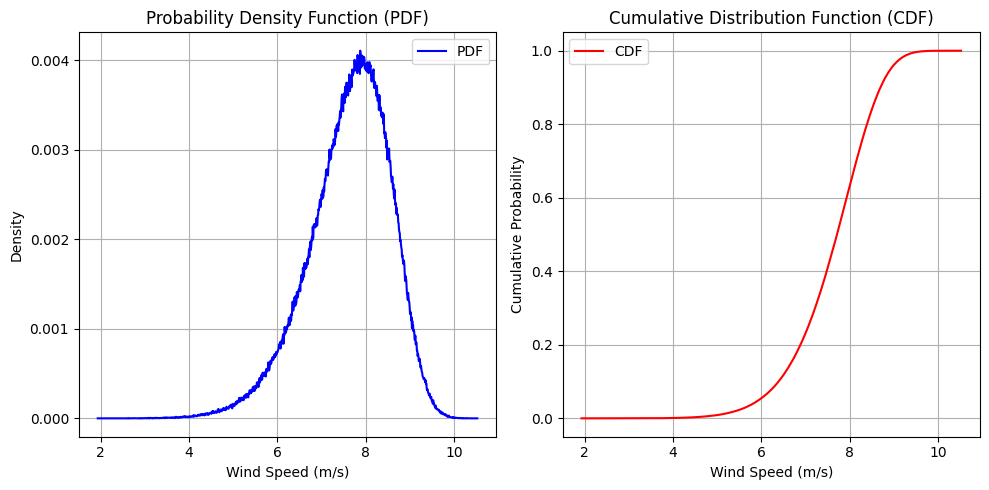

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import weibull_min

# Generate some synthetic wind speed data
Vwd = weibull_min.rvs(10., scale=8., size=int(1e6)) # generates 1,000,000 wind speed samples

def make_cdf(x, num_bins=1000):
    """
    Compute the empirical CDF of a given dataset.

    Parameters:
    x (array-like): Input data for which to compute the CDF.
    num_bins (int): Number of bins to use for the CDF estimation.

    Returns:
    x_range (numpy array): Sorted values of x for plotting.
    y (numpy array): Probability density function (PDF) values.
    z (numpy array): Cumulative distribution function (CDF) values.
    """
    # Define range for x
    min_x, max_x = np.min(x), np.max(x)
    x_range = np.linspace(min_x, max_x, num_bins)

    # Compute y: count occurrences in each bin
    y = np.zeros(len(x_range))
    for i in range(len(x_range) - 1):
        y[i+1] = np.sum((x >= x_range[i]) & (x < x_range[i+1]))

    # Normalize y to get a probability distribution
    y = y / np.sum(y)

    # Compute cumulative sum for the CDF
    z = np.zeros(len(y))
    for i in range(1, len(y)):
        z[i] = z[i-1] + y[i]

    return x_range, y, z


# Example usage with wind speed data
x_range, pdf_values, cdf_values = make_cdf(Vwd)

PM_low = np.median(Vwd)

# Plot the PDF and CDF
plt.figure(figsize=(10, 5))

# Plot PDF
plt.subplot(1, 2, 1)
plt.plot(x_range, pdf_values, label="PDF", color='b')
plt.xlabel("Wind Speed (m/s)")
plt.ylabel("Density")
plt.title("Probability Density Function (PDF)")
plt.grid(True)
plt.legend()

# Plot CDF
plt.subplot(1, 2, 2)
plt.plot(x_range, cdf_values, label="CDF", color='r')
plt.xlabel("Wind Speed (m/s)")
plt.ylabel("Cumulative Probability")
plt.title("Cumulative Distribution Function (CDF)")
plt.grid(True)
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

## Phase 2: Modeling Revenue Generation from Wind Power Production

After modeling wind speed as a Weibull distribution, the next step is to determine how wind speed translates into electricity generation and, consequently, revenue.

1. Wind Turbine Power Curve

The relationship between wind speed and power generation follows a standard wind turbine power curve, which consists of three key speed thresholds:
- Cut-in speed ($V_{\text{cut-in}}$): The minimum wind speed required for the turbine to start generating power.
- Rated speed ($V_{\text{rated}}$): The wind speed at which the turbine produces its maximum rated power output.
- Cut-out speed ($V_{\text{cut-out}}$): The maximum wind speed at which the turbine shuts down to prevent damage.

Using these parameters, we define the power output function:

\begin{equation}
P(V) =
\begin{cases} 
0, & V < V_{\text{cut-in}} \text{ or } V > V_{\text{cut-off}} \\
P_{\text{rated}} \cdot \dfrac{V^3 - V_{\text{cut-in}}^3}{V_{\text{rated}}^3 - V_{\text{cut-in}}^3}, & V_{\text{cut-in}} \leq V < V_{\text{rated}} \\
P_{\text{rated}}, & V_{\text{rated}} \leq V < V_{\text{cut-off}}
\end{cases}
\end{equation}

where $P_{\text{rated}}$ is the rated power output of the turbine.

2. Calculating Power Generation

We apply this function to each wind speed sample in our dataset to compute the corresponding power output

3. Computing Revenue from Power Generation

Revenue is determined using a fixed electricity price ($\lambda$) per MWh:

\begin{equation}
\text{Revenue} = \lambda \times P(V)
\end{equation}

where $\lambda$ is the price of electricity and $P(V)$ is the power output at wind speed $V$. With $\lambda = 0.06$ USD/MWh, we can calculate the revenue generated by each wind speed scenario.



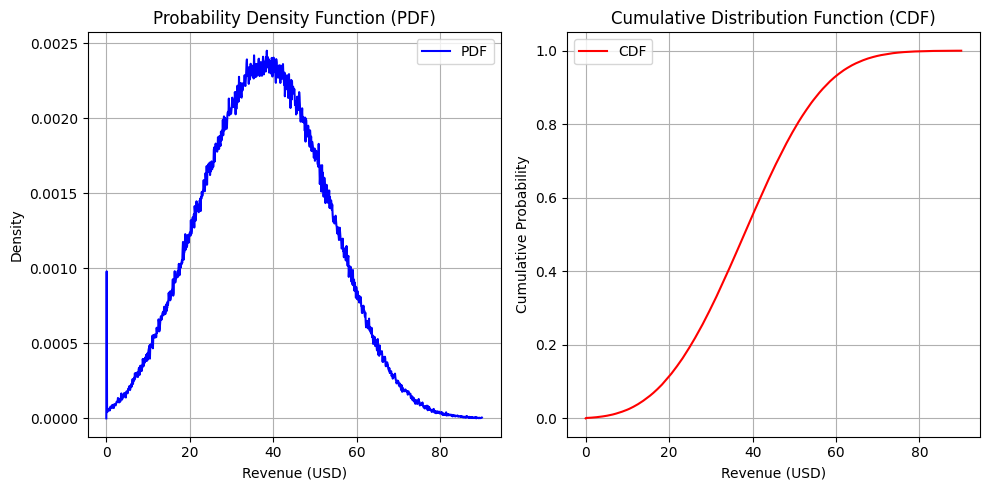

In [3]:
Cut_in = 4  # m/s (wind pseed must be at least this value to generate power)
Vw_rated = 10  # m/s (wind turbine operates at full capacity beyond this speed)
Cut_off = 30  # m/s (wind speeds above this value stop the turbine for safety)
P_rated = 1500  # kW (maximum output of the wind turbine)
Elec_daPrice = 0.06 # USD per Mwh


def power_output(Cut_in, Vw_rated, Cut_off, Vwd, P_rated):
    """
    Compute wind turbine power output based on wind speed.
    
    Parameters:
    Cut_in (float): Cut-in wind speed (m/s) below which no power is generated.
    Vw_rated (float): Rated wind speed (m/s) where the turbine reaches maximum output.
    Cut_off (float): Cut-off wind speed (m/s) above which the turbine stops.
    Vwd (numpy array): Wind speed values (m/s).
    P_rated (float): Rated power output of the wind turbine (kW).
    
    Returns:
    numpy array: Power output for each wind speed in Vwd.
    """
    pw = np.zeros_like(Vwd)  # Initialize power output array

    # Apply power curve logic
    for i in range(len(Vwd)):
        if Vwd[i] < Cut_in or Vwd[i] > Cut_off:
            pw[i] = 0  # No power generation outside operating range
        elif Cut_in <= Vwd[i] < Vw_rated:
            pw[i] = P_rated * ((Vwd[i] ** 3 - Cut_in ** 3) / (Vw_rated ** 3 - Cut_in ** 3))
        else:  # Vw_rated <= Vwd[i] < Cut_off
            pw[i] = P_rated  # Maximum rated power

    return pw

    

# Apply the power curve to each wind speed sample
gen = power_output(Cut_in, Vw_rated, Cut_off, Vwd, P_rated)
profitg = Elec_daPrice * gen

xg1_range, profitg_cm_pdf, profitg_cm_cdf = make_cdf(profitg)


# Plot the PDF and CDF
plt.figure(figsize=(10, 5))

# Plot PDF
plt.subplot(1, 2, 1)
plt.plot(xg1_range, profitg_cm_pdf, label="PDF", color='b')
plt.xlabel("Revenue (USD)")
plt.ylabel("Density")
plt.title("Probability Density Function (PDF)")
plt.grid(True)
plt.legend()

# Plot CDF
plt.subplot(1, 2, 2)
plt.plot(xg1_range, profitg_cm_cdf, label="CDF", color='r')
plt.xlabel("Revenue (USD)")
plt.ylabel("Cumulative Probability")
plt.title("Cumulative Distribution Function (CDF)")
plt.grid(True)
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()


## Phase 3: Expected Revenue Across Scenarios

Will the wind speed at this site be less than $v_e$?
- YES: Wind speed is below the threshold ($v < v_e$)
- NO: Wind speed is above the threshold ($v \geq v_e$)

To compute the expected revenue across different wind speed scenarios, we first identify the wind speed threshold $v_e$, which is the wind producer's belief about the expected wind speed over the hedging period.

Given the probability density function (PDF) of wind speed, $f_V(v)$, and the cumulative distribution function (CDF), $F_V(v)$, we categorize revenue calculations into two cases:

- Revenue when wind speed is below the threshold ($v < v_e$): This scenario corresponds to the CDF value at $v_e$, denoted as $p = F_V(v_e)$. We calculate the expected revenue by integrating the product of wind speed and PDF over the range $[0, v_e]$ (YES outcome).
- Revenue when wind speed is above the threshold ($v \geq v_e$): In this case, the expected revenue is computed by integrating the product of wind speed and PDF over the range $[v_e, \omega_{max}]$ (NO outcome).

1. Finding Threshold Index

We first locate the closest index in the dataset corresponding to the wind speed threshold $v_e$:

\begin{equation}
\text{index}_v = \arg \min |V_{\text{wind}} - v_e|
\end{equation}

where $V_{\text{wind}}$ represents the sampled wind speed data.

For revenue computation, we identify:
\begin{equation}
\text{index}_g = \arg \min |R_{\text{electricity}} - \lambda \cdot P(V_{\text{wind}})|
\end{equation}

where $\lambda$ is the electricity price and $P(V)$ is the power generation function.

2. Computing Expected Revenue in YES scenarios

The expected revenue in the case where the prediction market resolves **YES** (i.e., wind speed is below $v_e$ is computed as:

\begin{equation}
c = \int_{0}^{\omega(v_e)} \lambda \omega f_{\Omega}(\omega) d\omega
\end{equation}

In discrete form, this is approximated using numerical integration:

\begin{equation}
c \approx \sum_{i=1}^{\text{index}_g} R_i \cdot \text{PDF}_i \cdot \Delta x
\end{equation}


3. Computing Expected Revenue in NO scenarios

The expected revenue in the case where the prediction market resolves **NO** (i.e., wind speed is above $v_e$) is computed as:

\begin{equation}
g = \int_{\omega(v_e)}^{\omega_{\max}} \lambda \omega f_{\Omega}(\omega) d\omega
\end{equation}

Again, in discrete form, this is approximated as:

\begin{equation}
g \approx \sum_{i=\text{index}_g}^{N} R_i \cdot \text{PDF}_i \cdot \Delta x
\end{equation}

where $R_i$ represents revenue at a given wind speed.


In [4]:

# index min absoulte value 
index1_v = np.argmin(np.abs(x_range - PM_low))
index2_v = np.argmin(np.abs(Vwd - PM_low))
index1_g = np.argmin(np.abs(xg1_range - Elec_daPrice * gen[index2_v]))
# # Assuming xg1_range and profitg_cm_pdf are numpy arrays of the same length
Exp_R = np.trapezoid(profitg_cm_pdf * xg1_range)
p1g2 = profitg_cm_cdf[index1_g]

c = np.trapezoid(xg1_range[:index1_g] * profitg_cm_pdf[:index1_g])
g = np.trapezoid(xg1_range[index1_g:] * profitg_cm_pdf[index1_g:])
print(c)
print(g)

13.043785041012795
24.97179190389386


## Phase 4: Pricing and Utility

The wind producer (WPP) has an incentive to hedge its revenue uncertainty by participating in the prediction market. However, independent participants (speculators, traders, arbitrageurs) do not directly suffer from wind revenue fluctuations. Instead, they trade based purely on probabilities and risk-neutral considerations.

Thus, the pricing and utility framework will be different for:
- The Wind Producer: considers hedging benefits, expected revenue, and risk aversion
- Independent Participants: trades purely based on probability expectation without an exposure to wind revenue uncertainty

1. Indifference Pricing Strategy

Investor particpating a general binary prediction market with $U(w)$ utility function, with $w$ the wealth 

Indifference strategy achieved by solving the following equation:
\begin{equation}
pU(w_0 + n(1 - m)) + (1 - p)U(w_0 - nm) = U(w_0)
\end{equation}

where $w_0$ is the initial wealth, $n$ the number of shares purchased, $m$ the price of each share, and $p$ the probability of the event occuring.


For an independent a risk-averse participant with concave utility function (modelled exponentially) with the form $U(w) = - \exp(- b w)$, the indifference pricing strategy resolves in:

\begin{equation}
m = - \log (p \exp(-b n) + 1 - p) / bn
\end{equation}

which is non-linear decreasing function of the number of shares purchased $n$.
$b$ is the risk aversion degree of the investor, with higher values of $b$ indicating higher risk aversion. 

For the risk-averse wind producer, the utility function is defined as:

\begin{equation}
m = \frac{1}{n} \log \frac{p \exp (- bc) + (1 - p) \exp(-bg)}{p \exp(-bn -bc) + (1 - p) \exp (- bg)}
\end{equation}

taking into account the revenue uncertainty due to wind speed variability. The parameters $c$ and $g$ represent the expected revenue in the YES and NO scenarios, respectively.

1. Utility Maximization

Another approach to determine the trading volume in a binary prediction market with the aim of hedging is to maximise the expected value of the WPP's utility function. The expected utility value for an independent risk-averse participant is expressed as:

\begin{equation}
U(n,m) = p \exp (-b (n(1 - m) + w_0)) + (1 - p) \exp (-b (- nm))
\end{equation}

which is a concave function. Differentiating with respect to $n$ and solving $\frac{\partial U}{\partial n} = 0$ yields the price as a function of the number of shares purchased $n$ as follows:

\begin{equation}
m = \frac{p}{((1 - p) \exp (bn) + p)}
\end{equation}

Similarly, for a WPP the expected value of the utility can be expressed as:

\begin{equation}
U(n,m) = p \exp (-b (n(1 - m) + c)) + (1 - p) \exp (-b (- nm + g))
\end{equation}

where $c$ and $g$ represent the expected revenue in the YES and NO scenarios, respectively. Differentiating with respect to $n$ and solving $\frac{\partial U}{\partial n} = 0$ igives the price as a function of the number of shares purchased $n$ as:

\begin{equation}
m = \frac{p}{((1 - p) \exp (b(n - g +c)) + p)}
\end{equation}


0.5489561091739232
0.26966028053131424


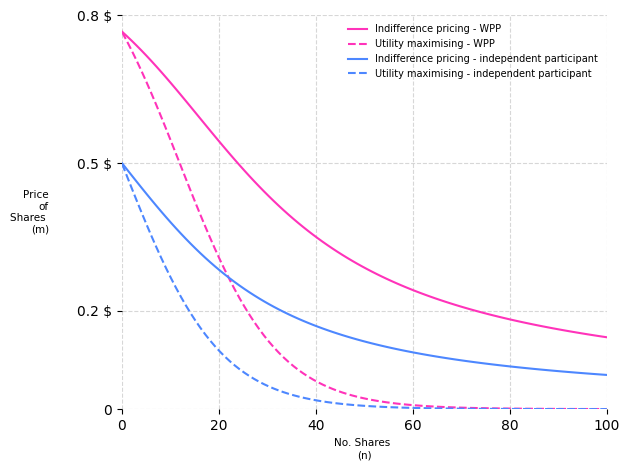

In [6]:
import scipy.stats as stats

b = 0.1
pd = stats.weibull_min(c=10, scale = 8)  # 'c' is the shape parameter (default 1 in MATLAB)
p1 = pd.cdf(PM_low)

PM_NShares1=10
N=1*PM_NShares1
P_r_indiff = np.log((p1*np.exp(-b * c) + (1 - p1)*np.exp(-b * g)) / (p1 * np.exp(-b * N - b*c)+(1 - p1) * np.exp(-b * g))) / (b * N)
P_r_umax = (((1 - p1) / p1) * np.exp(b * N - b * (g - c)) + 1) ** (-1)
P_r_m_1 = (((1 - p1) / p1) * np.exp(b * N) + 1) ** (-1)
P_r_e1 = (-np.log(p1 * np.exp(-b * N) + (1 - p1))) / (b * N)

print(P_r_umax)
print(P_r_m_1)

N = np.linspace(0.1, 100, 100)
P_r_indiff2 = np.log((p1*np.exp(-b * c) + (1 - p1)*np.exp(-b * g)) / (p1 * np.exp(-b * N - b*c)+(1 - p1) * np.exp(-b * g))) / (b * N)
P_r_umax2 = (((1 - p1) / p1) * np.exp(b * N - b * (g - c)) + 1) ** (-1)
P_r_m_12 = (((1 - p1) / p1) * np.exp(b * N) + 1) ** (-1)
P_r_e12 = (-np.log(p1 * np.exp(-b * N) + (1 - p1))) / (b * N)


# Corrected ylabel alignment to avoid error
plt.figure()  # Convert cm to inches for matplotlib

# Plot the curves
plt.plot(N, P_r_indiff2, '-', linewidth=1.5, color=(1, 0.2, 0.73), label="Indifference pricing - WPP")
plt.plot(N, P_r_umax2, '--', linewidth=1.5, color=(1, 0.2, 0.73), label="Utility maximising - WPP")
plt.plot(N, P_r_e12, '-', linewidth=1.5, color=(0.3, 0.53, 1), label="Indifference pricing - independent participant")
plt.plot(N, P_r_m_12, '--', linewidth=1.5, color=(0.3, 0.53, 1), label="Utility maximising - independent participant")

# Axis limits and labels
plt.xlim(0, 100)
plt.ylim(0, 0.8)
plt.yticks([0, 0.2, 0.5, 0.8], ['0', '0.2 $', '0.5 $', '0.8 $'])
plt.xlabel("No. Shares \n(n)", fontsize=7.5)

# Corrected vertical alignment
plt.ylabel("Price\nof\nShares \n(m)", fontsize=7.5, rotation=0, labelpad=20, verticalalignment='center', horizontalalignment='right')

# Customize legend
plt.legend(loc="upper right", fontsize=7, frameon=False)

# Grid and layout adjustments
plt.grid(True, linestyle="--", alpha=0.5)
plt.box(False)
plt.tight_layout()

# Show plot
plt.show()


The maximum price that can be offered by risk-averse participants, to purchase the specific number of shares based on the indifference pricing strategy or the utility maximising approaches are show in the figure above. Both approaches result in higher prices that can be offered by a hedger, here the wind producer, in comparison to standalone participants. 

These findings justify the viability of the proposed idea since it implies that his hedger would be willing to pay higher prices and would benefit the speculators which creates market opportunity. Can also be infer from this figure that the indifference pricing is always higher than maximizing utility pricing for both an independent participant as well as the wind producer.

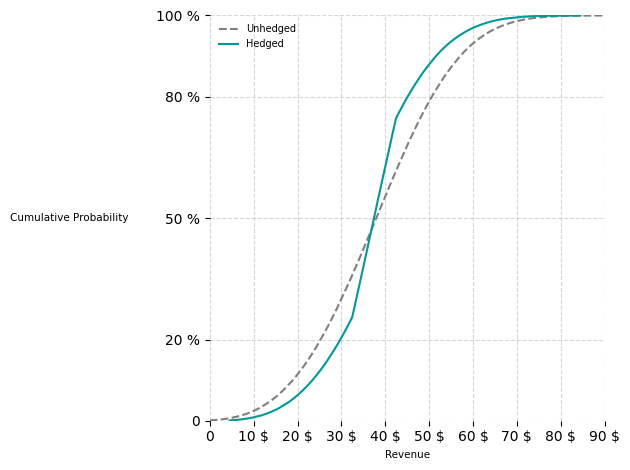

In [ ]:
def Payoff_PMw(PM_low, Vwd):
    """
    Compute binary prediction market payoff 
    """
    PM_Payoff = np.where(Vwd < PM_low, 1, 0)
    return PM_Payoff

def combined_profit(PM_low, PM_Price, PM_NShares, 
                    , Elec_daPrice, Cut_in, Vw_rated, Cut_off, Vwd, P_rated):
    
    """
    Compute the profit including electricity market revenue and hedging via prediction markets.
    """
    gen = power_output(Cut_in, Vw_rated, Cut_off, Vwd, P_rated)
    PM_Payoff = Payoff_PMw(PM_low, Vwd)
    Actual_revenue = Elec_daPrice * gen
    # compute total profit including prediction market hedge 
    profitw = Actual_revenue + (PM_NShares * (PM_Payoff - PM_Price))

    return profitw

PM_NShares1=10
Price_range = [0.35, P_r_umax, 0.75]
PM_high = 8 + 2 


profit_cm = np.zeros((len(Vwd), len(Price_range)))
xp_range = np.zeros((len(xg1_range), len(Price_range)))
profit_cm_pdf = np.zeros((len(xg1_range), len(Price_range)))
profit_cm_cdf = np.zeros((len(xg1_range), len(Price_range)))

for i in range(len(Price_range)):
    PM_Price = Price_range[i]
    profitw = combined_profit(PM_low, 
                            PM_high, 
                            PM_Price, 
                            PM_NShares1, 
                            Elec_daPrice, 
                            Cut_in, 
                            Vw_rated, 
                            Cut_off, 
                            Vwd, 
                            P_rated)
    
    profit_cm[:, i] = profitw
    xp_range_intermediary, profit_cm_pdf_intermediary, profit_cm_cdf_intermediary = make_cdf(profitw)
    xp_range[:, i] = xp_range_intermediary
    profit_cm_pdf[:, i] = profit_cm_pdf_intermediary
    profit_cm_cdf[:, i] = profit_cm_cdf_intermediary




plt.figure()
# Unhedged CDF (original profit without prediction market hedge)
plt.plot(xg1_range, profitg_cm_cdf, '--', linewidth=1.5, color=[0.5, 0.5, 0.5], label="Unhedged")

# Hedged CDF (profit with hedging applied via prediction market)
plt.plot(xp_range[:,1], profit_cm_cdf[:,1], '-', linewidth=1.5, color=[0, 0.6, 0.6], label="Hedged")

# # Mark median electricity price * generation
# plt.plot(Elec_daPrice * power_output(Cut_in, Vw_rated, Cut_off, Vwd, P_rated)[index2_v] - 0.2, 0.5, '*', color=[255/255, 99/255, 71/255], label="Median")

# Customize axis limits and labels
plt.xlim(0, 90)
plt.ylim(0, 1)
plt.xticks(np.arange(0, 100, 10), ['0', '10 $', '20 $', '30 $', '40 $', '50 $', '60 $', '70 $', '80 $', '90 $'])
plt.yticks([0, 0.2, 0.5, 0.8, 1], ['0', '20 %', '50 %', '80 %', '100 %'])
plt.xlabel("Revenue", fontsize=7.5)
plt.ylabel("Cumulative Probability", fontsize=7.5, rotation=0, labelpad=20, verticalalignment='center', horizontalalignment='right')

# Customize legend
plt.legend(loc="upper left", fontsize=7, frameon=False)

# Grid and layout adjustments
plt.grid(True, linestyle="--", alpha=0.5)
plt.box(False)
plt.tight_layout()

# # Show plot
plt.show()

If the producer purchases 10 YES shares ($n = 10$) with a price of $m = 0.55$ USD per share, as the price in the utility maximising strategy, the CDF of their revenue will be as above.
The revenue will be in a more predictable range by reducing the variance and the downside risk at the cost of reducing the maximum possible revenue.

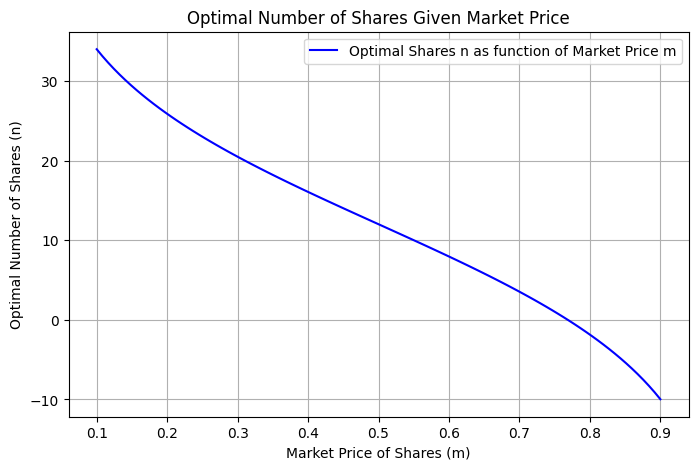

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
b = 0.1  # Risk aversion coefficient
p = 0.5  # Probability from wind speed CDF
c = 13   # Expected revenue when wind speed is below threshold
g = 25   # Expected revenue when wind speed is above threshold

# Function to compute optimal n given market price m
def optimal_n_given_m(m):
    """ Computes optimal number of shares given the market price m. """
    return g - c + (1 / b) * np.log((p / (1 - p)) * ((1 / m) - 1))

# Range of possible market prices for shares (between 0 and 1)
m_values = np.linspace(0.1, 0.9, 100)  # Market prices from 0.1 to 0.9 USD
n_values = np.array([optimal_n_given_m(m) for m in m_values])

# Plot the relationship between m and n
plt.figure(figsize=(8, 5))
plt.plot(m_values, n_values, label="Optimal Shares n as function of Market Price m", color='b')
plt.xlabel("Market Price of Shares (m)")
plt.ylabel("Optimal Number of Shares (n)")
plt.title("Optimal Number of Shares Given Market Price")
plt.legend()
plt.grid()
plt.show()
